# Random Projections

### Rishi Advani, Madison Crim, Sean O'Hagan

#### July 10, 2020

# Eigenfaces

In order to apply some of our work, we decided to apply the deterministic and randomized variants of the SVD on a larger dataset. We chose to use the [LFW](http://vis-www.cs.umass.edu/lfw/) (labeled faces in the wild) dataset, containing ~$8000$ $250\times 250$ RGB images. We load a subset (1000 images) of the data and center it as follows:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%cd ..
from eigenutil import *
%cd -

C:\Users\Sean\random-projections
(187500, 500)
(187500, 500)
C:\Users\Sean\random-projections\presentations


### Examples

Let's look at some of the faces in the dataset

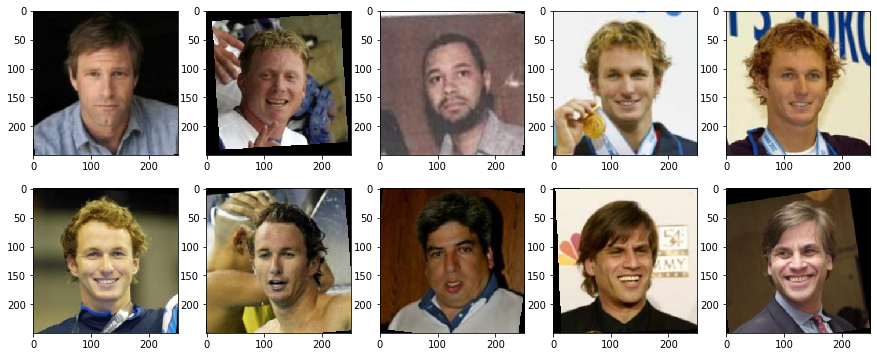

In [2]:
plot_examples(2,5)

We can flatten each image to represent it as vector of length $250\cdot 250 \cdot 3 = 187500$. This yields a data matrix $A$ of size $(1000,187500)$, which we may now manipulate. After computing the singular value decomposition,
$$A = U \Sigma V^*$$,
the columns of $U$ represent an orthonormal basis for the span of the original data, ordered in accordance to their corresponding singular values, from greatest to least. Thus, we may truncate $U$ and use the first $k$ columns as a basis for rank $k$ approximation.

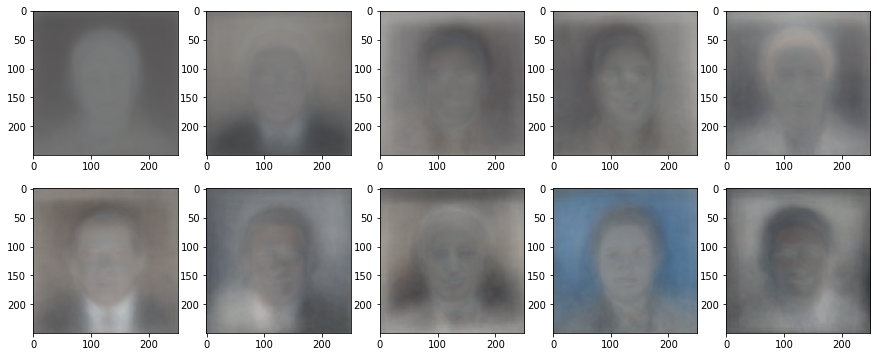

In [3]:
plot_eigenfaces(normalized_det_basis, 2, 5)

Similarly to deterministic SVD, we may utilize random SVD for this task as well. As a refresher, given a desired rank $k$ and an oversampling parameter $p$, we compute a randomized SVD in the following way:

- Define $l=k+p$.
- Let $\Omega \in \mathbb{R}^{n\times l}$, with $\Omega_{ij} \sim N(0,1)$
- Define $Y = A \Omega$
- Compute an orthonormal basis for the columns of $Y$ (i.e. with $QR$ decomposition)
- Define $B = Q^* A$. Note $B$ has dimension $l\times n$
- Compute the SVD of B, $B=\tilde{U}\Sigma V^*$, and let $U = Q\tilde{U}$, yielding $A\approx U\Sigma V^*$

Below is the columns of $U$ obtained using Randomized SVD

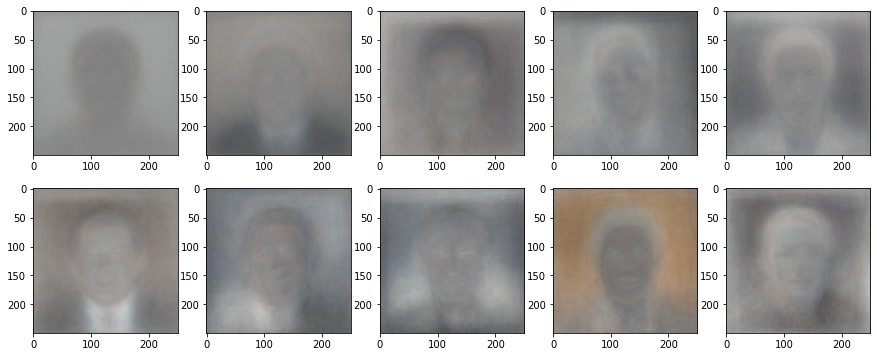

In [4]:
plot_eigenfaces(normalized_rand_basis, 2, 5)

Now that we have a basis, we may represent arbitrary vectors in our image space as linear combinations of basis vectors. To do this, we solve the linear system
$$A\vec{x}=\vec{b}-m$$
where $A$ denotes the matrix of which our basis vectors are columns, $\vec{b}$ denotes our specific image, and $m$ denotes the (column) mean of the dataset. Since we know our basis is orthonormal, we can use a shortcut, computing the coefficients $\vec{x}$ as 
$$\vec{x} = (\vec{b}-m)A$$

Below are examples of approximating images at a certain rank after a change of basis. The reason why this technique is useful is that any arbitrary image thought to be similar to those in the dataset may be represented fairly well using this basis.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


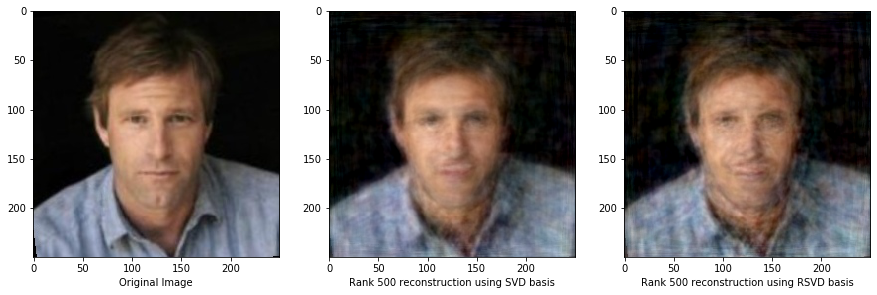

In [5]:
reconstruct(specific_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


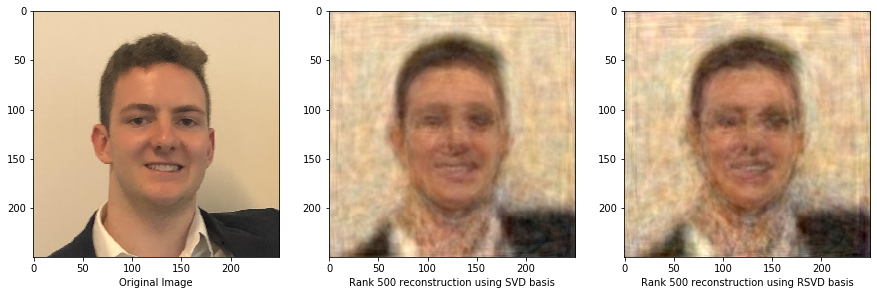

In [6]:
sean = np.asarray(Image.open('../examples/sean250.png')).flatten() / 255
reconstruct(sean)

Please enjoy the follow animations:

Random Guy | Sean | President Obama | Ellie Goulding
- | - | - | -
![Guy](../examples/guy250.png) | ![Sean](../examples/sean250.png) | ![Pres](../examples/president_obama250.png) | ![Ellie](../examples/ellie250.png)
![Anim](../examples/guy.gif) | ![Anim](../examples/sean.gif) | ![Anim](../examples/pres.gif) | ![Anim](../examples/ellie.gif)


### How to get better results?

- Use more data or a larger dataset
- Train with data that is representative of the data you wish to test with
- Standardize the position and scale of the face within the image

We now perform an analysis on the cost and accuracy of these methods, as the rank $k$ of the approximation varies. We see an inverse relationship between these quantities, as expected.

Computing RSVD with rank k=100...
Computing RSVD with rank k=200...
Computing RSVD with rank k=300...
Computing RSVD with rank k=400...


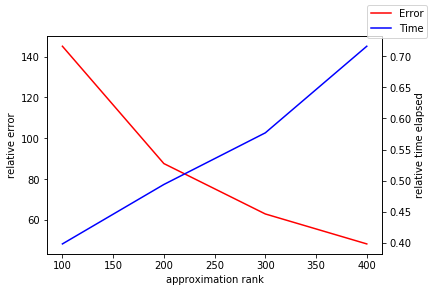

In [7]:
domain = np.arange(100, 500, step=100)

rand_times = []
errors = []

for k in domain:
    print(f'Computing RSVD with rank k={k}...')
    
    det_basis = svd_rank_k(k)
    det_approx = det_basis @ np.diag(SSigma[:k]) @ VVh[:k]
    
    start = perf_counter()
    rand_approx = rsvd_rank_k(k, return_approx=True)
    end = perf_counter()
    rand_time = end - start
    
    rand_times.append(rand_time / det_time)
    
    error = np.linalg.norm(rand_approx - det_approx) / np.linalg.norm(approx) #relative error between rsvd and svd
    #if we want, we can look at relative error between rsvd and data as well
    errors.append(error)


fig, ax = plt.subplots()

ax.set_xlabel('approximation rank')

ax.plot(domain, errors, c='r', label='Error')
ax.set_ylabel('relative error')

ax2 = ax.twinx()

ax2.plot(domain, rand_times, c='b', label='Time')
ax2.set_ylabel('relative time elapsed')

fig.legend(loc='upper right')

Finally, since the randomized SVD is a random process, we may sample it and provide statistical information. Again, due to concentration of measure, note the extremely low standard deviation in the error.

Sampling with rank k=100
Sampling with rank k=200
Sampling with rank k=300
Sampling with rank k=400


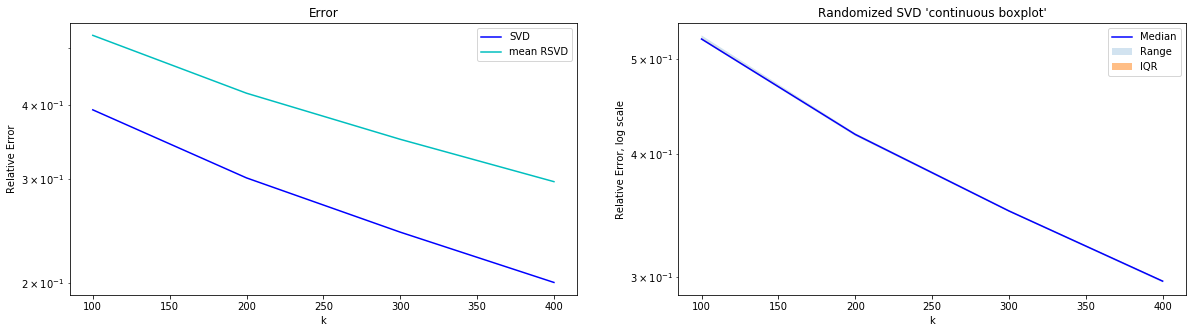

For k=200: Mean=0.29693339253673057, StDev=0.0004120264860488161


In [11]:
n_sample = 10
rsvd_error = np.empty((domain.shape[0], n_sample))
svd_error = np.empty(domain.shape[0])

rsvd_stat = np.empty((7,domain.shape[0]))

for i in range(domain.shape[0]):
    print(f'Sampling with rank k={domain[i]}')
    svd_error[i] = np.linalg.norm((det_U[:,:domain[i]] @ np.diag(SSigma[:domain[i]]) @ VVh[:domain[i]]) - data) / np.linalg.norm(data)
    for j in range(n_sample):
        rsvd_error[i][j] = np.linalg.norm(rsvd_rank_k(domain[i],return_approx=True) - data) / np.linalg.norm(data)

for i in range(domain.shape[0]):
    rsvd_stat[0][i] = np.min(rsvd_error[i])
    rsvd_stat[1][i] = np.quantile(rsvd_error[i], 0.25)
    rsvd_stat[2][i] = np.median(rsvd_error[i])
    rsvd_stat[3][i] = np.quantile(rsvd_error[i], 0.75)
    rsvd_stat[4][i] = np.max(rsvd_error[i])
    rsvd_stat[5][i] = np.mean(rsvd_error[i])
    rsvd_stat[6][i] = np.std(rsvd_error[i])

fig, ax = plt.subplots(1,2, figsize=(20,5))

ax[0].plot(domain, svd_error, c='b', label='SVD')
ax[0].plot(domain, rsvd_stat[5], c='c', label='mean RSVD')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Error')

ax[1].plot(domain, rsvd_stat[2], c='b', label='Median')
ax[1].fill_between(domain, rsvd_stat[4], rsvd_stat[0], alpha=0.2, label='Range', lw=1)
ax[1].fill_between(domain, rsvd_stat[1], rsvd_stat[3], alpha=0.5, label='IQR', lw=1)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Relative Error, log scale')
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Randomized SVD \'continuous boxplot\'')


plt.show()

print(f"For k=200: Mean={rsvd_stat[5][3]}, StDev={rsvd_stat[6][3]}")